I figured out after some trial and error that the data could be modelled by changing the environmental temperature variable. I did this manually using if statements, but with more research and time I believe I could find an equation for modelling the change in the temperature of the environment (when the hot plate is turned on, this represents increasing the environmental temperature. As the hot plate is left off, the temperature of the environment goes to the room temperature). For now, I made approximate guesses based on the data in order to get models that approximate the shape of the data.

In [729]:
import csv 
from matplotlib import pyplot as plt
import numpy as np

In [730]:
try:
    import pint
except ImportError:
    !pip install pint

In [731]:
from os.path import exists

filename = 'modsim.py'
if not exists(filename):
    from urllib.request import urlretrieve
    url = 'https://raw.githubusercontent.com/AllenDowney/ModSim/main/'
    local, _ = urlretrieve(url+filename, filename)
    print('Downloaded ' + local)
from modsim import *

In [732]:
def extract(filename):
    #get time, on/off status, and temperature from txt file
    results = []
    with open(filename) as tsv:
        for column in zip(*[line for line in csv.reader(tsv, dialect="excel-tab")]):
            columnFloat = []
            for val in list(column):
                columnFloat.append(float(val))
            results.append(columnFloat)
    return results

def onOffParse(data):
    #splits the results from extract() into two lists based on the on/off status
    offX = []
    offY = []
    onX = []
    onY = []
    for i in list(range(len(data[0]))):
        row = [data[0][i], data[1][i], data[2][i]]
        if row[1] == 0:
            offX.append(row[0])
            offY.append(row[2])
        if row[1] == 1:
            onX.append(row[0])
            onY.append(row[2])
    return [[offX, offY],[onX, onY]]

def onOffPlot(data, title="Time vs Temperature of Hotplate"):
    #plots the on and off points as well as conects them with a line
    dataParse = onOffParse(data)
    f = plt.figure()
    plt.plot(data[0], data[2], c='grey', zorder=0)
    plt.scatter(dataParse[0][0], dataParse[0][1], s=50, c='black', zorder=5, label="Hotplate off")
    plt.scatter(dataParse[1][0], dataParse[1][1], s=50, c='red', zorder=10, label="Hotplate on")
    plt.legend(loc="upper left")
    plt.xlabel("Time (sec)")
    plt.ylabel("Temperature (°C)")
    plt.title(title)
    f.savefig(str(title) + ".pdf", bbox_inches='tight')
    return f;

In [733]:
offLow = extract("C:/Users/smada/OneDrive/Documents/off_to_low.txt")
lowMed = extract("C:/Users/smada/OneDrive/Documents/low_to_med.txt")
medHigh = extract("C:/Users/smada/OneDrive/Documents/med_to_high.txt")

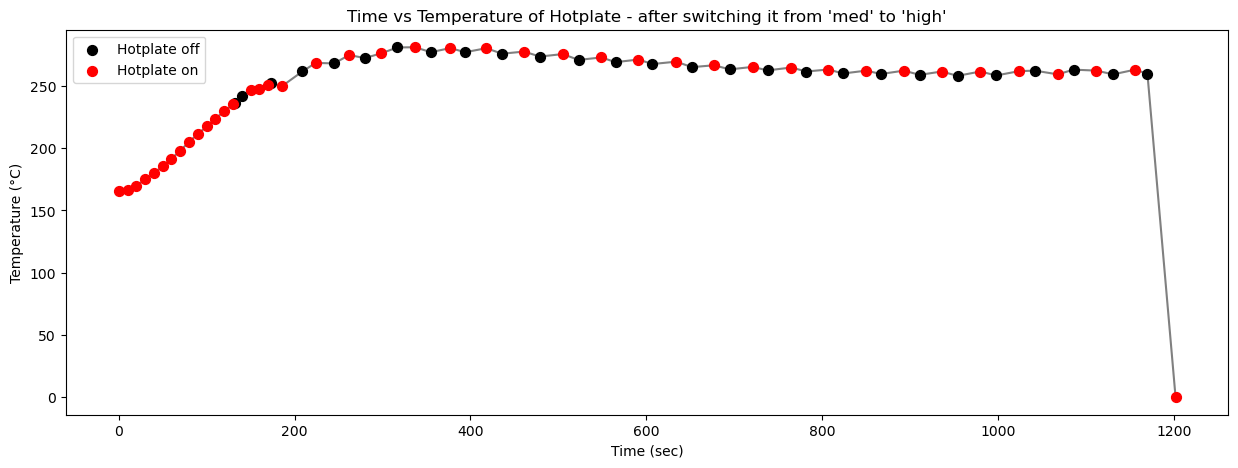

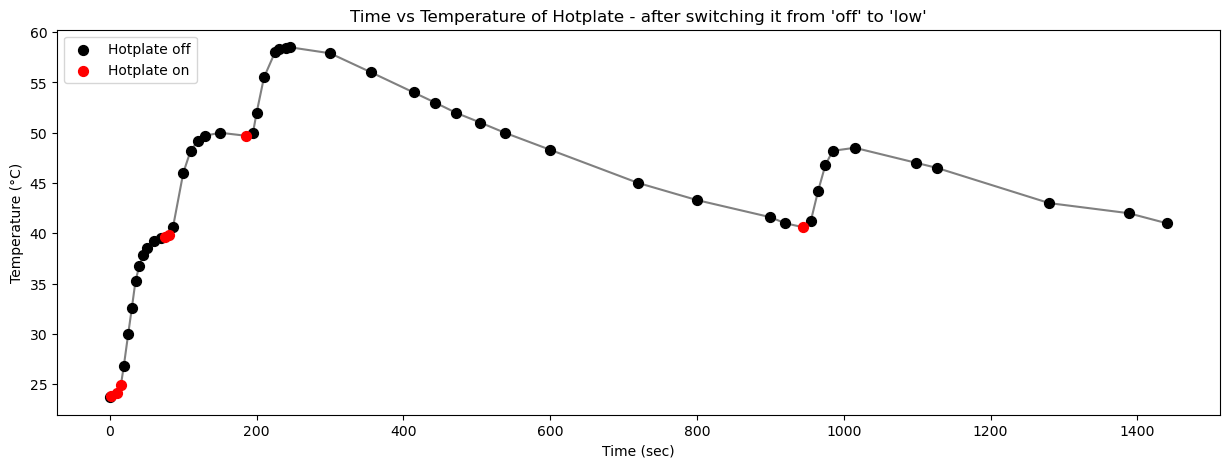

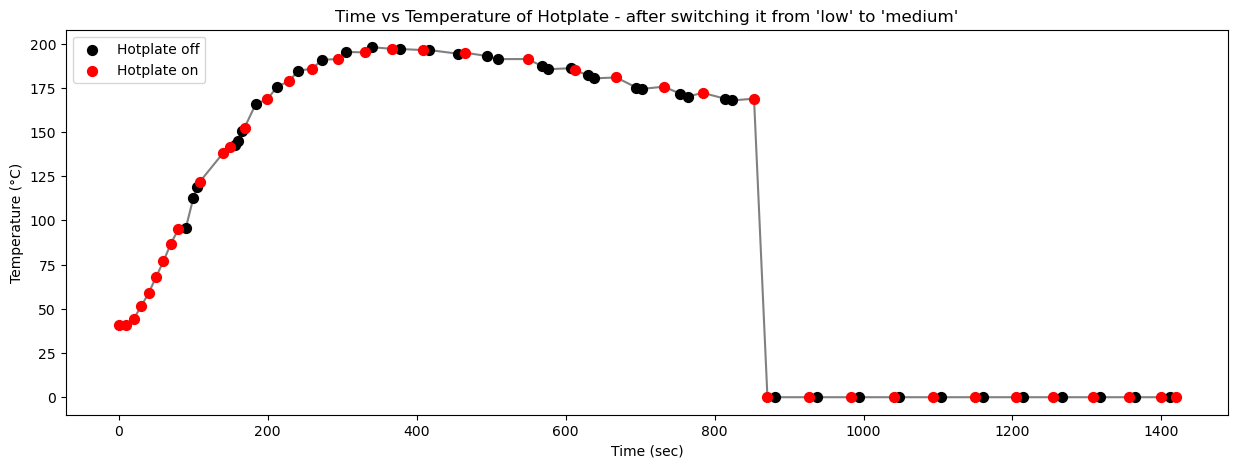

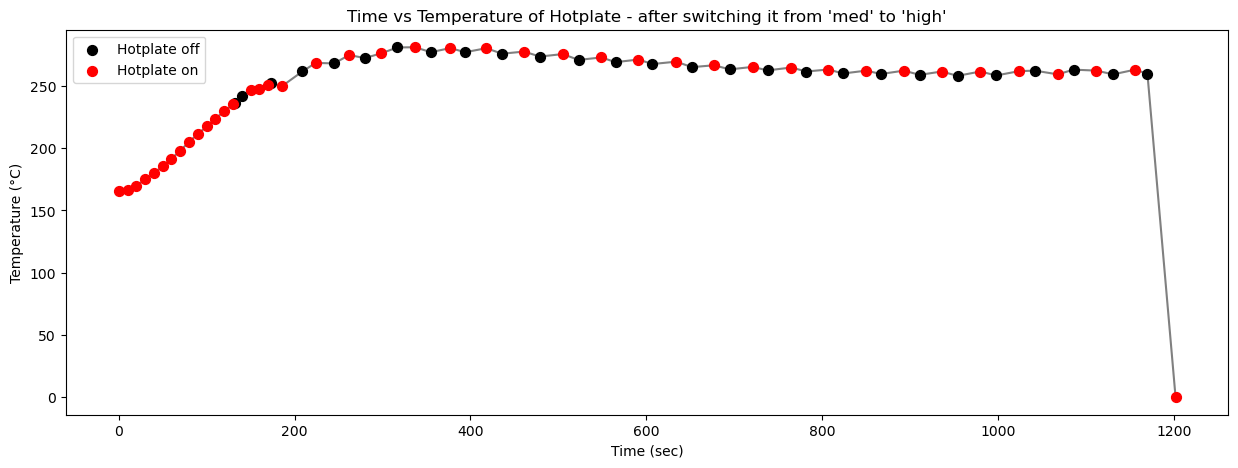

In [734]:
plt.rcParams['figure.figsize'] = [15, 5]

onOffPlot(offLow, "Time vs Temperature of Hotplate - after switching it from 'off' to 'low'")
onOffPlot(lowMed, "Time vs Temperature of Hotplate - after switching it from 'low' to 'medium'")
onOffPlot(medHigh, "Time vs Temperature of Hotplate - after switching it from 'med' to 'high'")

In [735]:
plate = System(T_init=23.7,
                  T_final=23.7,
                  r=.1,
                  t_end=1450,
                  T_env=40,
                  t_0=0,
                  dt=1)

In [736]:
def change_func(t, T, system, T_env):
    r, dt = system.r, system.dt    
    return -r * (T - T_env) * dt

In [737]:
def offLowParameters(i):
    if (i < 90):
        T_env = 40
        r = .04
    elif (i < 200):
        T_env = 50
        r = .1
    elif (i < 270):
        T_env = 59
        r = .1
    elif (i < 950):
        T_env = 31
        r = 0.0015
    elif (i < 1050):
        T_env = 48
        r = .1
    else:
        T_env = 31
        r = 0.0015
    return (T_env, r)

In [738]:
def lowMedParameters(i):
    if (i < 500):
        T_env = 197
        r = .008
    else:
        T_env = 100
        r = 0.001
    return (T_env, r)

In [739]:
def medHighParameters(i):
    if (i < 500):
        T_env = 281.1
        r = .008
    else:
        T_env = 200
        r = 0.0007
    return (T_env, r)

In [740]:
def run_simulation(system, change_func, parameter_func):
    t_array = linrange(system.t_0, system.t_end, system.dt)
    n = len(t_array)
    
    series = TimeSeries(index=t_array)
    series.iloc[0] = system.T_init
    
    for i in range(n-1):
        (T_env, system.r) = parameter_func(i)
        t = t_array[i]
        T = series.iloc[i]
        series.iloc[i+1] = T + change_func(t, T, system, T_env)
    
    system.T_final = series.iloc[-1]
    return series

C:\Users\smada\Documents\modsim.py:664: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  series = pd.Series(*args, **kwargs)


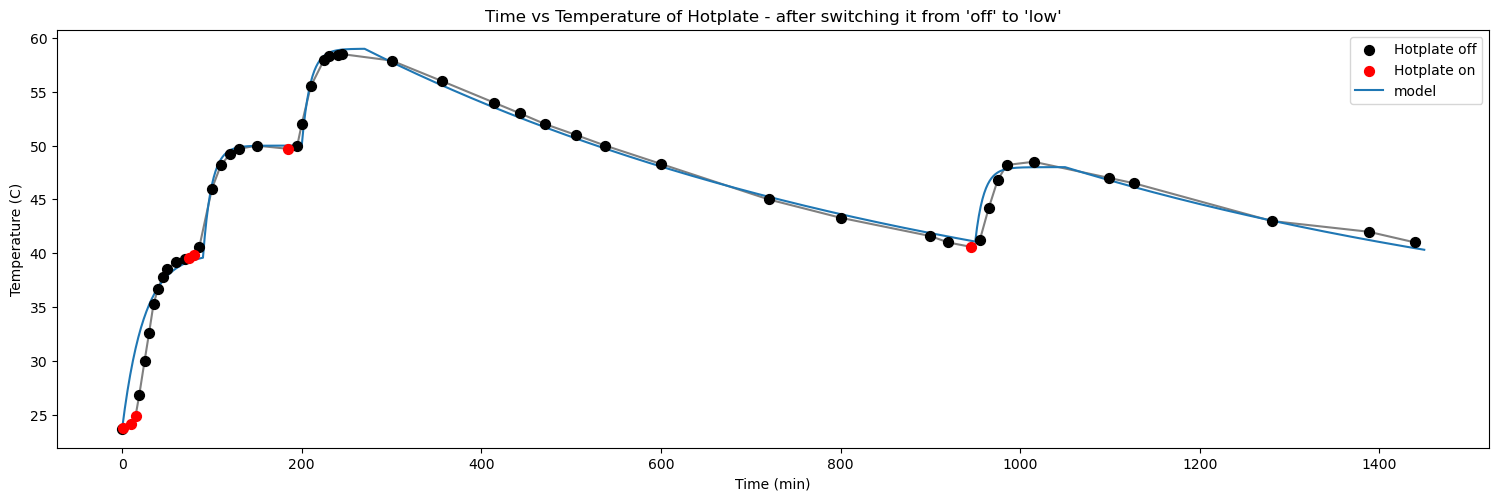

In [741]:
offLowResults = run_simulation(plate, change_func, offLowParameters)
onOffPlot(offLow, "Time vs Temperature of Hotplate - after switching it from 'off' to 'low'")
offLowResults.plot(label='model')
decorate(xlabel='Time (min)',
         ylabel='Temperature (C)')

C:\Users\smada\Documents\modsim.py:664: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  series = pd.Series(*args, **kwargs)


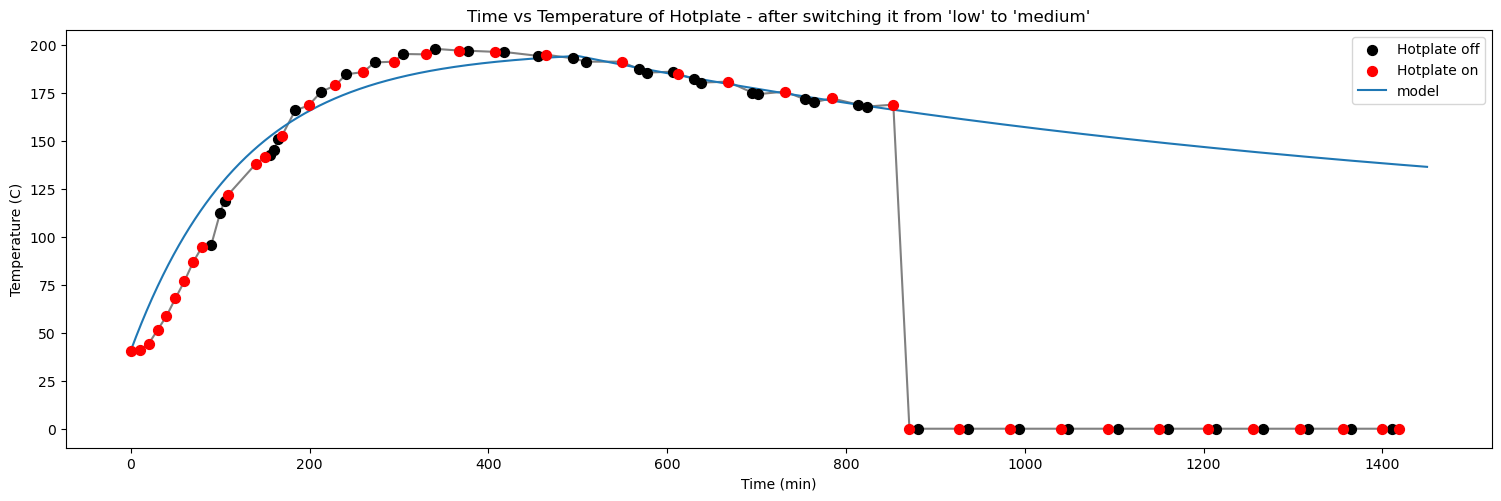

In [742]:
plate.T_init = 40.6
plate.T_final = 40.6
lowMedResults = run_simulation(plate, change_func, lowMedParameters)
onOffPlot(lowMed, "Time vs Temperature of Hotplate - after switching it from 'low' to 'medium'")
lowMedResults.plot(label='model')
decorate(xlabel='Time (min)',
         ylabel='Temperature (C)')

C:\Users\smada\Documents\modsim.py:664: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  series = pd.Series(*args, **kwargs)


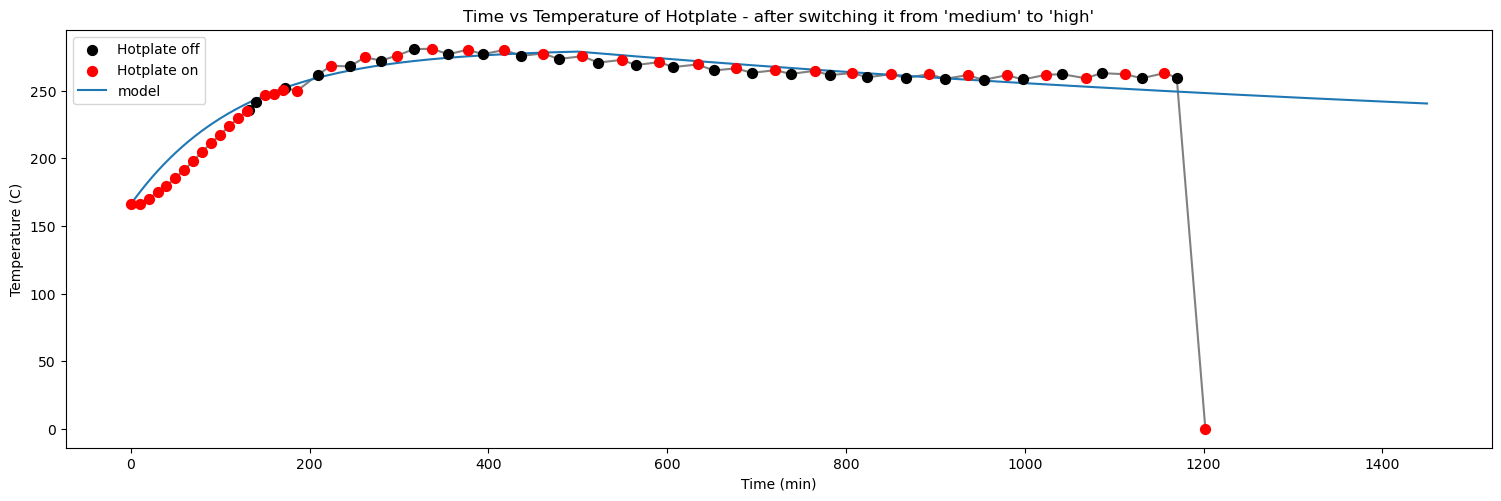

In [743]:
plate.T_init = 166
plate.T_final = 166
medHighResults = run_simulation(plate, change_func, medHighParameters)
onOffPlot(medHigh, "Time vs Temperature of Hotplate - after switching it from 'medium' to 'high'")
medHighResults.plot(label='model')
decorate(xlabel='Time (min)',
         ylabel='Temperature (C)')